In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install dgl

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 10.6 MB/s 
     |████████████████████████████████| 3.5 MB 10.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 13.0 MB/s 


In [3]:
import numpy as np
import pandas as pd
import time

import networkx as nx
import dgl
from dgl.nn.pytorch.conv import GraphConv, APPNPConv

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

import torch.nn as nn
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GATConv, BatchNorm, GraphNorm, GCNConv, DenseGraphConv, DenseSAGEConv, GATv2Conv
from torch_geometric.nn import global_mean_pool, dense_diff_pool, dense_mincut_pool
from torch_geometric.utils import to_dense_adj, to_dense_batch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette="rocket")
seed = 666

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load data

In [5]:
ell_features_all = pd.read_csv("/content/drive/MyDrive/Augmented_Elliptic/raw/elliptic_txs_features.csv", header = None)
df_features = pd.read_csv("/content/drive/MyDrive/Augmented_Elliptic/raw/elliptic_txs_features.csv", header = None)
ell_edges = pd.read_csv("/content/drive/MyDrive/Augmented_Elliptic/raw/elliptic_txs_edgelist.csv")
ell_classes = pd.read_csv('/content/drive/MyDrive/Original_Elliptic/raw/elliptic_txs_classes.csv')
clovr_classes = pd.read_csv("/content/drive/MyDrive/Augmented_Elliptic/elliptic_txs_classes_augmented_input.csv")

### Non-geometric data

In [6]:
# rename the classes to ints that can be handled by pytorch as labels
ell_classes["label"] = ell_classes["class"].replace(
    {"unknown": -1,  # unlabeled nodes
     "2": 0,  # labeled licit nodes
     #"1": 1,  # labeled illicit nodes
    }
).astype(int)

clovr_classes["label"] = clovr_classes["class"].fillna(-1)
clovr_classes["label"] = clovr_classes["label"].replace(
    {-1: -1,  # unlabeled nodes
     0: 0,  # labeled licit nodes
     1: 1,  # labeled illicit nodes on input or output
     2: 1,  # labeled illicit nodes on input and output
    }
).astype(int)

# rename features according to data description in paper
rename_dict = dict(
    zip(
        range(0, 167),
        ["txId", "time_step"]
        + [f"local_{i:02d}" for i in range(1, 94)]
        + [f"aggr_{i:02d}" for i in range(1, 73)],
    )
)
ell_features_all.rename(columns=rename_dict, inplace=True)

ell_features_local = ell_features_all.iloc[:,0:95]

In [7]:
# store to use on feature importances
names = ell_features_all.columns[2:167]
names

Index(['local_01', 'local_02', 'local_03', 'local_04', 'local_05', 'local_06',
       'local_07', 'local_08', 'local_09', 'local_10',
       ...
       'aggr_63', 'aggr_64', 'aggr_65', 'aggr_66', 'aggr_67', 'aggr_68',
       'aggr_69', 'aggr_70', 'aggr_71', 'aggr_72'],
      dtype='object', length=165)

In [8]:
print(ell_classes['label'].value_counts())
print(clovr_classes['label'].value_counts())

-1    157205
 0     42019
 1      4545
Name: label, dtype: int64
-1    157234
 0     39720
 1      6815
Name: label, dtype: int64


In [9]:
# put dataset together
ds_ell_all = pd.concat([ell_features_all, ell_classes["label"]], axis = 1)
ds_ell_local = pd.concat([ell_features_local, ell_classes["label"]], axis = 1)
ds_clovr_all = pd.concat([ell_features_all, clovr_classes["label"]], axis = 1)
ds_clovr_local = pd.concat([ell_features_local, clovr_classes["label"]], axis = 1)

In [10]:
print(ds_ell_all['label'].value_counts())
print(ds_clovr_all['label'].value_counts())

-1    157205
 0     42019
 1      4545
Name: label, dtype: int64
-1    157234
 0     39720
 1      6815
Name: label, dtype: int64


In [11]:
# remove unknown classes
ds_ell_all = ds_ell_all.dropna(axis = 0)
ds_ell_local = ds_ell_local.dropna(axis = 0)
ds_clovr_all = ds_clovr_all.dropna(axis = 0)
ds_clovr_local = ds_clovr_local.dropna(axis = 0)

ds_ell_all = ds_ell_all[ds_ell_all.label!=-1]
ds_ell_local = ds_ell_local[ds_ell_local.label!=-1]
ds_clovr_all = ds_clovr_all[ds_clovr_all.label!=-1]
ds_clovr_local = ds_clovr_local[ds_clovr_local.label!=-1]

print(len(ds_ell_all))
print(len(ds_clovr_all))

46564
46535


In [12]:
print(ds_ell_all['label'].value_counts())
print(ds_clovr_all['label'].value_counts())

0    42019
1     4545
Name: label, dtype: int64
0    39720
1     6815
Name: label, dtype: int64


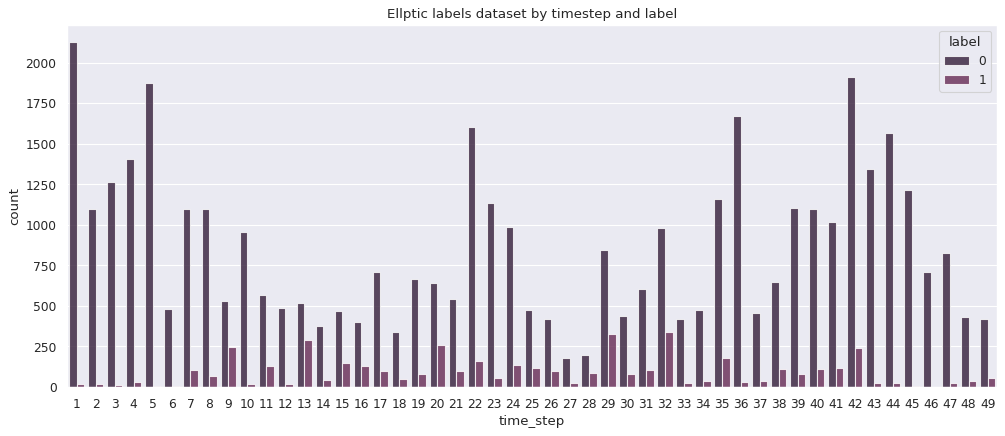

In [13]:
# plot records by timestep
fig, ax = plt.subplots(figsize=(15, 6), dpi=80)
sns.countplot(data=ds_ell_all, x='time_step', alpha=0.8, hue='label' )
ax.set_title('Ellptic labels dataset by timestep and label');
#plt.xticks(np.arange(1, 50, 1.0));

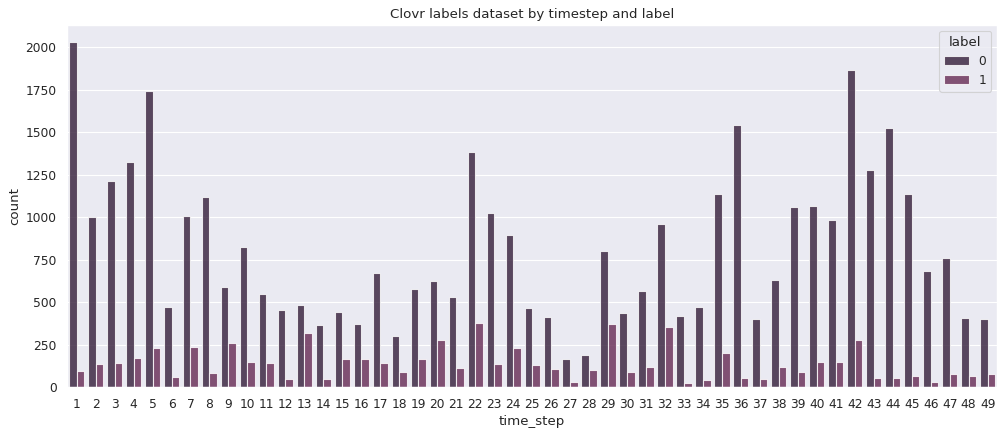

In [14]:
# plot records by timestep
fig, ax = plt.subplots(figsize=(15, 6), dpi=80)
sns.countplot(data=ds_clovr_all, x='time_step', alpha=0.8, hue='label' )
ax.set_title('Clovr labels dataset by timestep and label');


In [15]:
# combine elliptic and clover for labels graph
temp1 = ds_ell_all[['time_step','label']].copy()
temp1['type'] = 'elliptic'
temp2 = ds_clovr_all[['time_step','label']].copy()
temp2['type'] = 'clovr'
merged = pd.concat([temp1, temp2]).reset_index()

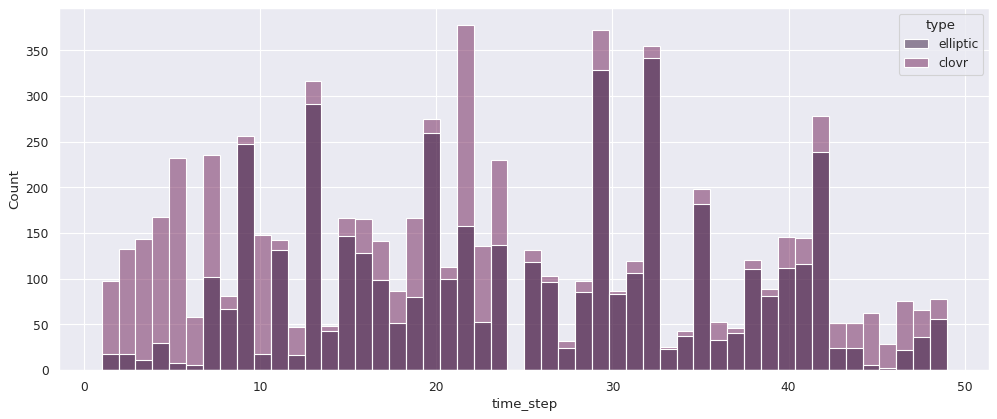

In [18]:
# plot records by timestep
fig, ax = plt.subplots(figsize=(15, 6), dpi=80)
sns.histplot(data=merged[merged.label==1], x='time_step', alpha=0.5, bins=50, hue='type');
#ax.set_title('');

### Geometric data

In [19]:
columns = {0: 'txId', 1: 'time_step'}
df_features = df_features.rename(columns=columns)
x = torch.from_numpy(df_features.loc[:, 2:].values).to(torch.float)

# There exists 3 different classes in the dataset:
clovr_classes_geom = clovr_classes
clovr_classes_geom["class"] = clovr_classes_geom["class"].replace(0, "2")
clovr_classes_geom["class"] = clovr_classes_geom["class"].replace(1, "1")
clovr_classes_geom["class"] = clovr_classes_geom["class"].fillna("unknown")
# 0=licit,  1=illicit, 2=unknown
mapping = {'unknown': 2, '1': 1, '2': 0}
clovr_classes_geom['class'] = clovr_classes_geom['class'].map(mapping)
y = torch.from_numpy(clovr_classes_geom['class'].values)

#creates a mapping dictionary of the transaction ID and the index from the features
mapping = {idx: i for i, idx in enumerate(ell_features_all['txId'].values)}

#maps the transaction ID in edges to an index
ell_edges_geom = ell_edges
ell_edges_geom['txId1'] = ell_edges_geom['txId1'].map(mapping)
ell_edges_geom['txId2'] = ell_edges_geom['txId2'].map(mapping)

#transposes the edges and turns into tensor
edge_index_geom = torch.from_numpy(ell_edges_geom.values).t().contiguous()

# Timestamp based split:
time_step = torch.from_numpy(ell_features_all['time_step'].values)
train_mask = (time_step < 35) & (y != 2)
test_mask = (time_step >= 35) & (y != 2)

input_data = Data(x=x, edge_index=edge_index_geom, y=y, train_mask=train_mask, test_mask=test_mask)

## Auxiliary Functions

In [20]:
# split dataset into train ant test according to timestep limit
def prepare_train_test(dataset, ts_limit):
  xtrain = dataset.loc[dataset.iloc[:,1]<= ts_limit]
  xtrain = xtrain.iloc[:,2:]
  ytrain = xtrain["label"]
  xtrain = xtrain.drop("label", axis = 1)

  xtest = dataset.loc[dataset.iloc[:,1]> ts_limit]
  xtest = xtest.iloc[:,2:]
  ytest = xtest["label"]
  xtest = xtest.drop("label", axis = 1)
  return xtrain, ytrain, xtest, ytest

# run model pipleline, gridsarch and fit
def run_model(model, grid_values, sampling):
  #Pipeline
  if sampling == 'under':
    pipe = imbPipeline([('preprocessing', preprocessing.StandardScaler()),
                        ('sampling', RandomUnderSampler(sampling_strategy = 'majority', random_state=seed)),
                        ('classifier', model)])
  elif sampling == 'over':
    pipe = imbPipeline([('preprocessing', preprocessing.StandardScaler()),
                        ('sampling', RandomOverSampler(sampling_strategy = 'minority', random_state=seed)),
                        ('classifier', model)])
  else:
    pipe = imbPipeline([('preprocessing', preprocessing.StandardScaler()),
                        ('classifier', model)])

  # Grid
  grid_values = grid_values
               
  #Run grid search
  grid = GridSearchCV(pipe, param_grid = grid_values, scoring = 'roc_auc', cv = 10, verbose = 3, n_jobs = 3)

  #Fit model
  grid.fit(xtrain, ytrain)
  return grid

# get accuracy, precision, recall and f1 scores given ytrue and ypred
def get_scores(ytrue, ypred, ypred_proba):
  roc_auc = roc_auc_score(ytrue, ypred_proba)
  acc = accuracy_score(ytrue, ypred)
  prec = precision_score(ytrue, ypred, zero_division=0)
  rec = recall_score(ytrue, ypred, zero_division=0)
  f1 = f1_score(ytrue, ypred, zero_division=0)
  scores = [roc_auc, acc, prec, rec, f1]
  return scores

# get scores by timestep and store them in a dataframe
def get_timestep_scores(dataset, ts_lower_limit, ypred, label_type):
  ts_list = list()
  acc_list = list()
  prec_list = list()
  rec_list = list()
  f1_list = list()
  count_list = list()
  lists = [acc_list, prec_list, rec_list, f1_list]
  
  ds = dataset[dataset.time_step>ts_lower_limit].copy()
  ds['label_pred'] = list(ypred)

  time_steps = np.unique(ds['time_step'])

  ts_score = pd.DataFrame(columns = ['type','time_step','acc','pre','rec','f1','samples'])
  
  for time_step in range(ts_lower_limit+1,50):
    tsytrue = ds[ds['time_step']==time_step]['label']
    tsypred = ds[ds['time_step']==time_step]['label_pred']
    
    count_list.append(sum(tsytrue))
    ts_list.append(time_step) 
    scores = get_scores(tsytrue, tsypred, tsypred)
    for item, lst in zip(scores, lists):
      lst.append(item)
  
  ts_score['type'],ts_score['time_step'], ts_score['acc'], ts_score['pre'], ts_score['rec'], ts_score['f1'], ts_score['samples'] = [label_type, ts_list, acc_list, prec_list, rec_list, f1_list, count_list]
  ts_score['type'] = label_type
  return ts_score

#Function for re-weighting probabilities to correct for class imbalance. 
def reweight(pi,q1,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

# function that plots confusion matrix given actual and predicted values
def plot_confusion(ytest, ypred):


    ypred = [1 if item>0.5 else 0 for item in ypred]

    conf_mat = confusion_matrix(ytest, ypred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig1, ax1 = plt.subplots(figsize=(8, 6));
    ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()

# utility function to obtain a confusion matrix
def eval_confusion_matrix(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
    plot_confusion(labels, indices)


# Baseline models

In [21]:
timestep_limit = 34
seed = 666
results = pd.DataFrame(columns=['model','auc','acc','pre','rec','f1'])

## Logistic regression

In [22]:
# get train and test
xtrain, ytrain, xtest, ytest = prepare_train_test(ds_clovr_all, timestep_limit)

In [23]:
#Check for class imbalance
unique, counts = np.unique(ytrain, return_counts=True)
class_counts = dict(zip(unique, counts))

# Calculate class weights
class0 = class_counts[0]/(class_counts[0] + class_counts[1])
class1 = class_counts[1]/(class_counts[0] + class_counts[1]) #q1

In [24]:
# run model
model = LogisticRegression(max_iter = 1000000, solver='lbfgs')
grid_values = [{'classifier__penalty':['l2']}]
grid_logit = run_model(model, grid_values, 'over')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


###Results

In [25]:
# show overall results
y_pred = grid_logit.predict(xtest)
y_pred_prob = grid_logit.predict_proba(xtest)
y_pred_prob = reweight(y_pred_prob, class1)

roc_auc, acc, prec, rec, f1 = get_scores(ytest, y_pred, y_pred_prob[:,1])
print(f'Scores: AUC: {roc_auc:.3f}, A: {acc:.3f}, P: {prec:.3f}, R: {rec:.3f}, F1: {f1:.3f}')

results = results.append({'model':'logit','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

Scores: AUC: 0.717, A: 0.629, P: 0.153, R: 0.676, F1: 0.249


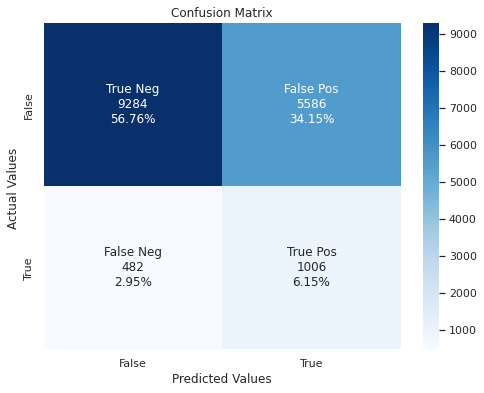

In [26]:
plot_confusion(ytest, y_pred)

In [27]:
# show results by timestep
score_logit = get_timestep_scores(ds_clovr_all, timestep_limit, y_pred, 'logit')

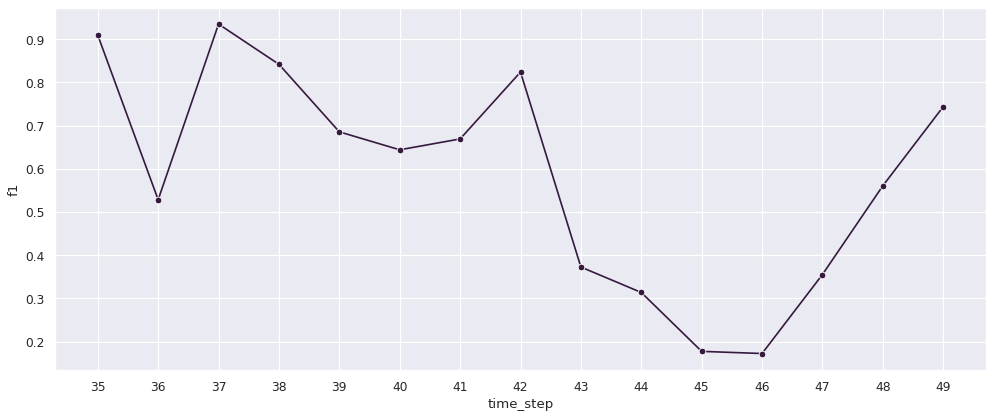

In [28]:
# plot results by timestep
fig, ax1 = plt.subplots(figsize=(15, 6), dpi=80)
sns.lineplot(data = score_logit, x='time_step', y='f1',palette='Dark2', marker='o', ax=ax1);
plt.xticks(np.arange(35, 50, 1.0));

## Random Forest

###Random Forest with clovr

In [29]:
# get train and test
xtrain, ytrain, xtest, ytest = prepare_train_test(ds_clovr_all, timestep_limit)

In [30]:
#Check for class imbalance
unique, counts = np.unique(ytrain, return_counts=True)
class_counts = dict(zip(unique, counts))

# Calculate class weights
class0 = class_counts[0]/(class_counts[0] + class_counts[1])
class1 = class_counts[1]/(class_counts[0] + class_counts[1])

In [31]:
# run model
model = RandomForestClassifier(random_state=seed, n_jobs=2)
grid_values = [{}]
grid_rf = run_model(model, grid_values, 'over')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


####Results

In [32]:
y_pred = grid_rf.predict(xtest)
y_pred_prob = grid_rf.predict_proba(xtest)
y_pred_prob = reweight(y_pred_prob, class1)

roc_auc, acc, prec, rec, f1 = get_scores(ytest, y_pred, y_pred_prob[:,1])
print(f'Scores: AUC: {roc_auc:.3f}, A: {acc:.3f}, P: {prec:.3f}, R: {rec:.3f}, F1: {f1:.3f}')
results = results.append({'model':'rf','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

Scores: AUC: 0.902, A: 0.955, P: 0.964, R: 0.528, F1: 0.683


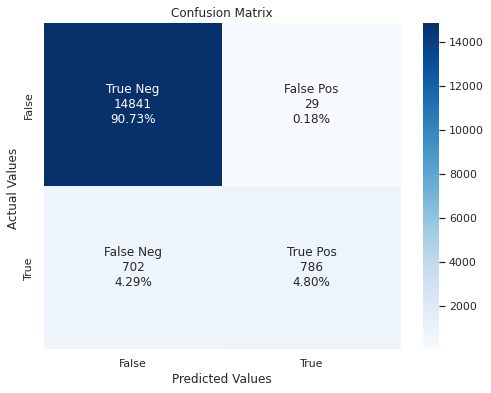

In [33]:
plot_confusion(ytest, y_pred)

In [34]:
score_clovr = get_timestep_scores(ds_clovr_all, timestep_limit, y_pred, 'rf clovr')

###Random forest with elliptic

In [35]:
# get train and test
xtrain, ytrain, xtest, ytest = prepare_train_test(ds_ell_all, timestep_limit)

In [36]:
model = RandomForestClassifier(random_state=seed, n_jobs=3)
grid_values = [{}]
grid_rf_ell = run_model(model, grid_values, 'over')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


####Results

In [37]:
y_pred = grid_rf_ell.predict(xtest)
y_pred_prob = grid_rf_ell.predict_proba(xtest)
y_pred_prob = reweight(y_pred_prob,class1)

roc_auc, acc, prec, rec, f1 = get_scores(ytest, y_pred, y_pred_prob[:,1])
print(f'Scores: AUC: {roc_auc:.3f}, A: {acc:.3f}, P: {prec:.3f}, R: {rec:.3f}, F1: {f1:.3f}')
results = results.append({'model':'rf elliptic','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

Scores: AUC: 0.937, A: 0.979, P: 0.953, R: 0.717, F1: 0.818


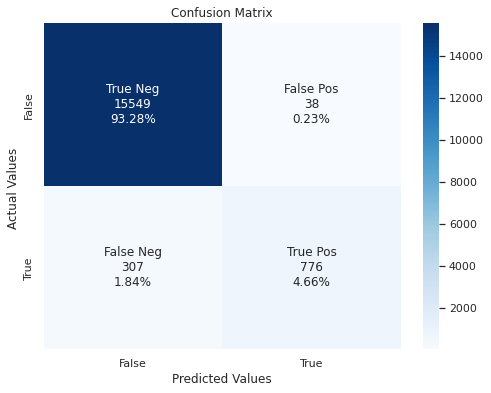

In [38]:
plot_confusion(ytest, y_pred)

In [39]:
# get scores by timestep
score_ell = get_timestep_scores(ds_ell_all, timestep_limit, y_pred, 'rf elliptic')

### F1 comparison vs Weber

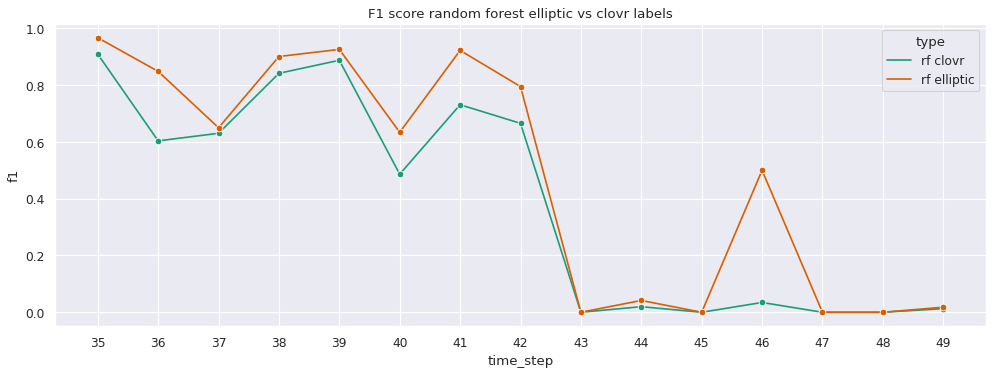

In [40]:
merged = pd.concat([score_clovr, score_ell]).reset_index()
fig, ax1 = plt.subplots(figsize=(15, 5), dpi=80)
sns.lineplot(data = merged, x='time_step', y='f1',palette='Dark2', marker='o', hue='type', ax=ax1);
ax1.set_title('F1 score random forest elliptic vs clovr labels')
plt.xticks(np.arange(35, 50, 1.0));

### Recall comparison vs Weber

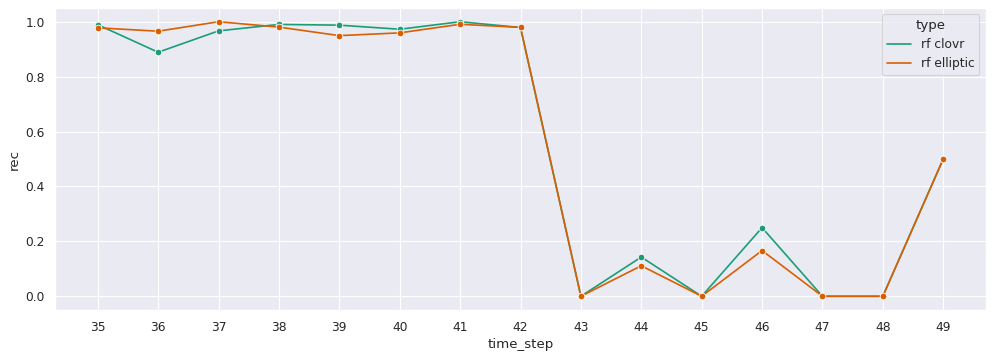

In [41]:

fig, ax1 = plt.subplots(figsize=(15, 5), dpi=80)
sns.lineplot(data = merged, x='time_step', y='rec',palette='Dark2', marker='o', hue='type', ax=ax1);
#ax1.set_title('Recall score random forest elliptic vs clovr labels')
plt.xticks(np.arange(35, 50, 1.0));


###Feature importances

In [42]:
# Extract feature importances and calculate cumulative sum of importances
feature_importances = pd.DataFrame(grid_rf.best_estimator_.named_steps['classifier'].feature_importances_, index =names,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances['cumulative_importance'] = feature_importances.importance.cumsum()

In [43]:
feature_importances.to_csv('/content/drive/MyDrive/transaction_feature_importances.csv')

In [44]:
feature_importances

,importance,cumulative_importance
local_53,0.035259,0.035259
local_47,0.034219,0.069478
local_41,0.033566,0.103044
local_55,0.031949,0.134993
local_90,0.025891,0.160884
...,...,...
local_38,0.000561,0.999025
aggr_42,0.000485,0.999509
local_70,0.000332,0.999842
local_07,0.000155,0.999996


## GAT

###Architecture

In [45]:
#weighting the loss function - giving the illicit transactions as a higher weight
class_weights = torch.FloatTensor([0.5,1]).to(device)

In [46]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads, dropout):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.batchnorm1 = BatchNorm(dim_h*heads)
    
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.batchnorm2 = BatchNorm(dim_out*heads)

    self.lin = Linear(dim_out*heads, dim_out)

    self.dropout = dropout

  def forward(self, x, edge_index):

    x = self.gat1(x, edge_index)
    x = F.leaky_relu(x)
    x = self.batchnorm1(x)
    
    x = self.gat2(x, edge_index)
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = F.leaky_relu(x)
    x = self.batchnorm2(x)

    x = self.lin(x)

    return x, F.log_softmax(x, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def trainGAT(model, data, optimizer):
    """Train a GNN model and return the trained model."""
    epochs = 1000
    data = data.to(device)
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss(weight = class_weights)
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc_train = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        #Test
        ypred = out[data.test_mask].argmax(dim=1).cpu()
        ytrue = data.y[data.test_mask].cpu()
        roc_auc, acc_test, prec, rec, f1 = get_scores(ytrue, ypred, ypred)

        # Print metrics every 10 epochs
        if(epoch % 100 == 0):
            print(f'Epoch {epoch:>3} |'
                  f'Train Loss: {loss:.3f} | '
                  f'Train Acc: {acc_train*100:>6.2f}% | '
                  f'Test Acc: {acc_test*100:.2f}% | '
                  f'Test Recall: {rec:.3f} | '
                  f'Test Precision: {prec:.3f} | '
                  f'Test F1: {f1:.3f}')
                  

    plot_confusion(ytrue, ypred)
    return roc_auc, acc_test, prec, rec, f1

def trainGCN(model, data, optimizer):
    """Train a GNN model and return the trained model."""
    epochs = 1000
    data = data.to(device)
    model.to(device)
    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight = class_weights)
        acc_train = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        #Test
        ypred = out[data.test_mask].argmax(dim=1).cpu()
        ytrue = data.y[data.test_mask].cpu()
        roc_auc, acc_test, prec, rec, f1 = get_scores(ytrue, ypred, ypred)

        # Print metrics every 10 epochs
        if(epoch % 100 == 0):
            print(f'Epoch {epoch:>3} |'
                  f'Train Loss: {loss:.3f} | '
                  f'Train Acc: {acc_train*100:>6.2f}% | '
                  f'Test Acc: {acc_test*100:.2f}% | '
                  f'Test Recall: {rec:.3f} | '
                  f'Test Precision: {prec:.3f} | '
                  f'Test F1: {f1:.3f}')
                  

    plot_confusion(ytrue, ypred)
    return roc_auc, acc_test, prec, rec, f1

In [47]:
gat_model = GAT(dim_in=input_data.num_features, dim_h=8, dim_out=2, heads=8, dropout=0.6).to(device)
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=0.0005)
print(gat_model)

GAT(
  (gat1): GATv2Conv(165, 8, heads=8)
  (batchnorm1): BatchNorm(64)
  (gat2): GATv2Conv(64, 2, heads=8)
  (batchnorm2): BatchNorm(16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


### Results

Epoch   0 |Train Loss: 0.872 | Train Acc:  58.34% | Test Acc: 58.25% | Test Recall: 0.329 | Test Precision: 0.078 | Test F1: 0.125
Epoch 100 |Train Loss: 0.210 | Train Acc:  92.88% | Test Acc: 91.66% | Test Recall: 0.417 | Test Precision: 0.555 | Test F1: 0.477
Epoch 200 |Train Loss: 0.179 | Train Acc:  93.87% | Test Acc: 91.07% | Test Recall: 0.433 | Test Precision: 0.511 | Test F1: 0.469
Epoch 300 |Train Loss: 0.137 | Train Acc:  95.27% | Test Acc: 91.07% | Test Recall: 0.449 | Test Precision: 0.511 | Test F1: 0.478
Epoch 400 |Train Loss: 0.128 | Train Acc:  95.62% | Test Acc: 91.75% | Test Recall: 0.394 | Test Precision: 0.567 | Test F1: 0.465
Epoch 500 |Train Loss: 0.137 | Train Acc:  94.84% | Test Acc: 90.23% | Test Recall: 0.358 | Test Precision: 0.453 | Test F1: 0.400
Epoch 600 |Train Loss: 0.111 | Train Acc:  96.24% | Test Acc: 90.10% | Test Recall: 0.431 | Test Precision: 0.454 | Test F1: 0.442
Epoch 700 |Train Loss: 0.104 | Train Acc:  96.70% | Test Acc: 91.01% | Test Recall:

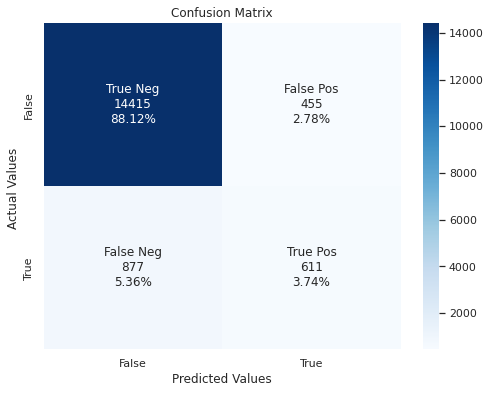

In [48]:
roc_auc, acc, prec, rec, f1 = trainGAT(gat_model, input_data, optimizer)

In [49]:
results = results.append({'model':'GAT','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

##GCN

###Architecture

In [50]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

class Net1(torch.nn.Module):
    def __init__(self, dataset):
        super(Net1, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [51]:
gcn_model = Net1(input_data)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=0.0005)
print(gcn_model)

Net1(
  (conv1): GCNConv()
  (conv2): GCNConv()
)


### Results

Epoch   0 |Train Loss: 0.760 | Train Acc:  47.15% | Test Acc: 52.43% | Test Recall: 0.387 | Test Precision: 0.077 | Test F1: 0.129
Epoch 100 |Train Loss: 0.468 | Train Acc:  83.65% | Test Acc: 85.05% | Test Recall: 0.437 | Test Precision: 0.288 | Test F1: 0.347
Epoch 200 |Train Loss: 0.446 | Train Acc:  85.56% | Test Acc: 86.32% | Test Recall: 0.446 | Test Precision: 0.320 | Test F1: 0.372
Epoch 300 |Train Loss: 0.430 | Train Acc:  85.29% | Test Acc: 87.53% | Test Recall: 0.414 | Test Precision: 0.345 | Test F1: 0.377
Epoch 400 |Train Loss: 0.423 | Train Acc:  85.53% | Test Acc: 86.51% | Test Recall: 0.427 | Test Precision: 0.319 | Test F1: 0.365
Epoch 500 |Train Loss: 0.422 | Train Acc:  85.42% | Test Acc: 87.43% | Test Recall: 0.374 | Test Precision: 0.331 | Test F1: 0.351
Epoch 600 |Train Loss: 0.418 | Train Acc:  86.03% | Test Acc: 87.85% | Test Recall: 0.413 | Test Precision: 0.355 | Test F1: 0.382
Epoch 700 |Train Loss: 0.416 | Train Acc:  85.89% | Test Acc: 87.52% | Test Recall:

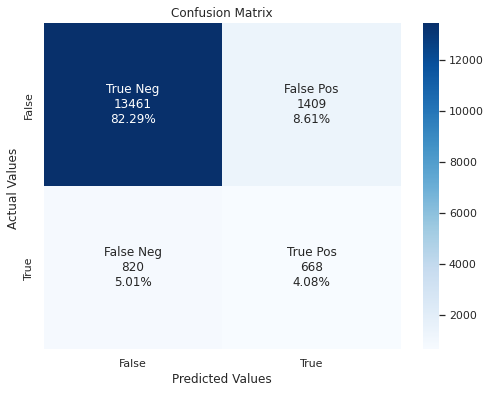

In [52]:
roc_auc, acc, prec, rec, f1 = trainGCN(gcn_model, input_data, optimizer)

In [53]:
results = results.append({'model':'GCN','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

##APPNP

####Load data

In [54]:
ell_features_all = pd.read_csv("/content/drive/MyDrive/Augmented_Elliptic/raw/elliptic_txs_features.csv", header = None)
ell_edges = pd.read_csv("/content/drive/MyDrive/Augmented_Elliptic/raw/elliptic_txs_edgelist.csv")
ell_classes = pd.read_csv('/content/drive/MyDrive/Original_Elliptic/raw/elliptic_txs_classes.csv')
clovr_classes = pd.read_csv("/content/drive/MyDrive/Augmented_Elliptic/elliptic_txs_classes_augmented_input.csv")

In [55]:
# rename the classes to ints that can be handled by pytorch as labels
ell_classes["label"] = ell_classes["class"].replace(
    {"unknown": -1,  # unlabeled nodes
     "2": 0,  # labeled licit nodes
     #"1": 1,  # labeled illicit nodes
    }
).astype(int)

clovr_classes["label"] = clovr_classes["class"].fillna(-1)
clovr_classes["label"] = clovr_classes["label"].replace(
    {-1: -1,  # unlabeled nodes
     0: 0,  # labeled licit nodes
     1: 1,  # labeled illicit nodes on input or output
     2: 1,  # labeled illicit nodes on input and output
    }
).astype(int)

# rename features according to data description in paper
rename_dict = dict(
    zip(
        range(0, 167),
        ["txId", "time_step"]
        + [f"local_{i:02d}" for i in range(1, 94)]
        + [f"aggr_{i:02d}" for i in range(1, 73)],
    )
)
ell_features_all.rename(columns=rename_dict, inplace=True)

ell_features_local = ell_features_all.iloc[:,0:95]

####Auxiliary functions

In [56]:
# utility function to evaluate the model
def evaluate(model, loss_fcn, features, labels, mask):
    """Calculate the loss, accuracy, precision, recall and f1_score for the masked data"""
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        loss = loss_fcn(logits, labels)
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        p, r, f, _ = precision_recall_fscore_support(labels, indices, zero_division=0)
        return loss, correct.item() * 1.0 / len(labels), p[1], r[1], f[1]
    

# utility function to obtain a confusion matrix
def eval_confusion_matrix(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
    plot_confusion(labels, indices)


###APPNP with clovr

In [57]:
# instantiate the multidirected graph
g_nx = nx.MultiDiGraph() 
# add nodes with the txid and a dictionary with the label
g_nx.add_nodes_from(zip(clovr_classes['txId'], [{'label': v} for v in clovr_classes['label']]))
# add edges
g_nx.add_edges_from(zip(ell_edges['txId1'], ell_edges['txId2']));
# convert to bidirectional
g_nx_bidirectional = g_nx.to_undirected().to_directed()
# convert to dgl format
g_bi = dgl.from_networkx(g_nx_bidirectional)
g_bi.ndata['label'] = torch.tensor(clovr_classes.set_index("txId").loc[sorted(g_nx.nodes()), "label"].values)
g_bi.ndata["features_matrix"] = torch.tensor(ell_features_local.set_index("txId").loc[sorted(g_nx.nodes()), :].values)
# add self loop to the bidirectional edges graph (normalization)
g_bi.add_edges(g_bi.nodes(), g_bi.nodes())
print(g_bi)

Graph(num_nodes=203769, num_edges=672479,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(94,), dtype=torch.float64)}
      edata_schemes={})


####Architecture

In [58]:
# Approximated Personalized Propagation of Neural Predictions
class APPNP(nn.Module):
    def __init__(
        self,
        g,
        in_feats,
        n_hidden,
        n_classes,
        n_layers,
        activation,
        feat_drop,
        edge_drop,
        alpha,
        k,
    ):
        super(APPNP, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(nn.Linear(in_feats, n_hidden))
        # hidden layers
        for _ in range(n_layers - 2):
            self.layers.append(nn.Linear(n_hidden, n_hidden))
        # output layer
        self.layers.append(nn.Linear(n_hidden, n_classes))
        self.activation = activation
        if feat_drop:
            self.feat_drop = nn.Dropout(feat_drop)
        else:
            self.feat_drop = lambda x: x
        self.propagate = APPNPConv(k, alpha, edge_drop)
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, features):
        # prediction step
        h = features
        h = self.feat_drop(h)
        h = self.activation(self.layers[0](h))
        for layer in self.layers[1:-1]:
            h = self.activation(layer(h))
        
        h = self.layers[-1](self.feat_drop(h))
        
        # propagation step
        h = self.propagate(self.g, h)
        return h

In [59]:
def train_eval_model(model, model_class, g, features, **params):
    
    #bidirectional = params["bidirectional"] if "bidirectional" in params else None
    in_feats = features.shape[1]
    n_classes = 2
    n_hidden = params["n_hidden"]
    n_layers = params["n_layers"]
    weight_decay = params["weight_decay"]
    bias = params["bias"]
    dropout = params["dropout"]
    epochs = params["epochs"]
    lr = params["lr"]
    posweight = params["posweight"]
    
    if model == 'APPNP' :
      alpha = params["alpha"]
      k = params["k"]
      model = model_class(g, in_feats, n_hidden, n_classes, n_layers, F.leaky_relu, dropout, bias, alpha, k)
    if model == 'GCN' or model == 'Simple':
      model = model_class(g, in_feats, n_hidden, n_classes, n_layers, F.leaky_relu, dropout, bias)
    
    # weighted cross entropy loss function
    loss_fcn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1 - posweight, posweight]))

    # use optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    dur = []
    metrics = {"loss":{"train": [], "val": []},
               "accuracy":{"train": [], "val": []},
               "precision":{"train": [], "val": []},
               "recall":{"train": [], "val": []},
               "f1_score":{"train": [], "val": []},
              }

    for epoch in range(epochs):
        model.train()
        if epoch >= 3:
            t0 = time.time()
        # forward pass
        logits = model(features)
        loss = loss_fcn(logits[train_indices], labels[train_indices])
        metrics["loss"]["train"].append(loss)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # duration
        if epoch >= 3:
            dur.append(time.time() - t0)
        # evaluate on training set
        _, train_acc, train_precision, train_recall, train_f1_score = evaluate(model, loss_fcn, features, labels, train_indices)
        metrics["accuracy"]["train"].append(train_acc)
        metrics["precision"]["train"].append(train_precision)
        metrics["recall"]["train"].append(train_recall)
        metrics["f1_score"]["train"].append(train_f1_score)
        # evaluate on validation set
        val_loss, val_acc, val_precision, val_recall, val_f1_score = evaluate(model, loss_fcn, features, labels, val_indices)
        metrics["loss"]["val"].append(val_loss)
        metrics["accuracy"]["val"].append(val_acc)
        metrics["precision"]["val"].append(val_precision)
        metrics["recall"]["val"].append(val_recall)
        metrics["f1_score"]["val"].append(val_f1_score)
        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch {epoch:05d} | Time(s) {np.mean(dur):.2f} | val_loss {val_loss.item():.4f} "
                f"| Precision {val_precision:.4f} | Recall {val_recall:.4f} | Acc {val_acc:.4f} "
                f"| F1_score {val_f1_score:.4f}"
            )

    print("Confusion matrix:")
    eval_confusion_matrix(model, features, labels, val_indices)
    return val_acc, val_precision, val_recall, val_f1_score

In [60]:
# prepare inputs for model
features = g_bi.ndata["features_matrix"].float()
labels = g_bi.ndata["label"].long()  # format required for cross entropy loss
in_feats = features.shape[1]
n_classes = 2  # licit or illicit (unknown label is ignored)
n_edges = g_bi.number_of_edges()

dataset_size = clovr_classes["label"].notna().sum()
train_ratio = 0.7
train_time_steps = round(len(np.unique(features[:, 0])) * train_ratio)
shutdown_timestep = 43
train_indices = (((features[:, 0] <= train_time_steps) & (labels != -1)).nonzero().view(-1))
val_indices = (((features[:, 0] > train_time_steps) & (labels != -1)).nonzero().view(-1))

print(f"""Number of timesteps used for training: {train_time_steps}
Number of timesteps used for validation: {dataset_size-train_time_steps}""")

Number of timesteps used for training: 34
Number of timesteps used for validation: 203735


####Results

Epoch 00099 | Time(s) 0.65 | val_loss 0.5422 | Precision 0.2858 | Recall 0.5349 | Acc 0.8361 | F1_score 0.3726
Epoch 00199 | Time(s) 0.65 | val_loss 0.4351 | Precision 0.5596 | Recall 0.5430 | Acc 0.9196 | F1_score 0.5512
Epoch 00299 | Time(s) 0.65 | val_loss 0.4265 | Precision 0.6309 | Recall 0.5376 | Acc 0.9293 | F1_score 0.5806
Epoch 00399 | Time(s) 0.65 | val_loss 0.4224 | Precision 0.6330 | Recall 0.5390 | Acc 0.9296 | F1_score 0.5822
Epoch 00499 | Time(s) 0.65 | val_loss 0.4276 | Precision 0.6354 | Recall 0.5410 | Acc 0.9300 | F1_score 0.5844
Epoch 00599 | Time(s) 0.65 | val_loss 0.4313 | Precision 0.6436 | Recall 0.5437 | Acc 0.9311 | F1_score 0.5894
Epoch 00699 | Time(s) 0.65 | val_loss 0.4248 | Precision 0.6076 | Recall 0.5504 | Acc 0.9268 | F1_score 0.5776
Epoch 00799 | Time(s) 0.65 | val_loss 0.4251 | Precision 0.6416 | Recall 0.5450 | Acc 0.9309 | F1_score 0.5894
Epoch 00899 | Time(s) 0.65 | val_loss 0.4295 | Precision 0.6545 | Recall 0.5437 | Acc 0.9324 | F1_score 0.5940
E

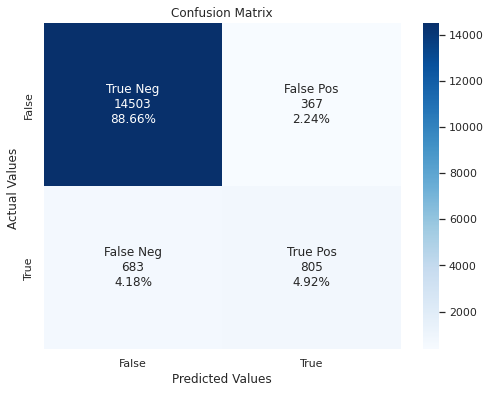

In [61]:
params_APPNP = {
    "n_hidden" : 256,
    "n_layers" : 2,
    "weight_decay" : 0.,
    "bias" : False,
    "dropout" : 0.2,
    "epochs" : 1000,
    "lr" : 0.001,
    "posweight" : 0.7,
    "alpha" : 0.2,
    "k" : 20,
}

# train on graph bidirectional edges
acc, prec, rec, f1 = train_eval_model('APPNP', APPNP, g_bi, features, **params_APPNP)

In [62]:
results = results.append({'model':'APPNP','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

###APPNP with elliptic classes

In [63]:
# instantiate the multidirected graph
g_nx = nx.MultiDiGraph() 
# add nodes with the txid and a dictionary with the label
g_nx.add_nodes_from(zip(ell_classes['txId'], [{'label': v} for v in ell_classes['label']]))
# add edges
g_nx.add_edges_from(zip(ell_edges['txId1'], ell_edges['txId2']));
# convert to bidirectional
g_nx_bidirectional = g_nx.to_undirected().to_directed()
# convert to dgl format
g_bi = dgl.from_networkx(g_nx_bidirectional)
g_bi.ndata['label'] = torch.tensor(ell_classes.set_index("txId").loc[sorted(g_nx.nodes()), "label"].values)
g_bi.ndata["features_matrix"] = torch.tensor(ell_features_local.set_index("txId").loc[sorted(g_nx.nodes()), :].values)
# add self loop to the bidirectional edges graph (normalization)
g_bi.add_edges(g_bi.nodes(), g_bi.nodes())
print(g_bi)

Graph(num_nodes=203769, num_edges=672479,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(94,), dtype=torch.float64)}
      edata_schemes={})


In [64]:
# prepare inputs for model
features = g_bi.ndata["features_matrix"].float()
labels = g_bi.ndata["label"].long()  # format required for cross entropy loss
in_feats = features.shape[1]
n_classes = 2  # licit or illicit (unknown label is ignored)
n_edges = g_bi.number_of_edges()

dataset_size = ell_classes["label"].notna().sum()
train_ratio = 0.7
train_time_steps = round(len(np.unique(features[:, 0])) * train_ratio)
shutdown_timestep = 43
train_indices = (((features[:, 0] <= train_time_steps) & (labels != -1)).nonzero().view(-1))
val_indices = (((features[:, 0] > train_time_steps) & (labels != -1)).nonzero().view(-1))

print(f"""Number of timesteps used for training: {train_time_steps}
Number of timesteps used for validation: {dataset_size-train_time_steps}""")

Number of timesteps used for training: 34
Number of timesteps used for validation: 203735


####Results

Epoch 00099 | Time(s) 0.65 | val_loss 0.3626 | Precision 0.2417 | Recall 0.7091 | Acc 0.8366 | F1_score 0.3606
Epoch 00199 | Time(s) 0.65 | val_loss 0.2734 | Precision 0.3852 | Recall 0.7128 | Acc 0.9074 | F1_score 0.5002
Epoch 00299 | Time(s) 0.65 | val_loss 0.2388 | Precision 0.4698 | Recall 0.7101 | Acc 0.9291 | F1_score 0.5654
Epoch 00399 | Time(s) 0.65 | val_loss 0.2263 | Precision 0.5434 | Recall 0.7165 | Acc 0.9425 | F1_score 0.6181
Epoch 00499 | Time(s) 0.65 | val_loss 0.2149 | Precision 0.5910 | Recall 0.7193 | Acc 0.9494 | F1_score 0.6489
Epoch 00599 | Time(s) 0.65 | val_loss 0.2058 | Precision 0.6509 | Recall 0.7128 | Acc 0.9565 | F1_score 0.6805
Epoch 00699 | Time(s) 0.65 | val_loss 0.2035 | Precision 0.6437 | Recall 0.7175 | Acc 0.9558 | F1_score 0.6786
Epoch 00799 | Time(s) 0.65 | val_loss 0.2016 | Precision 0.6454 | Recall 0.7193 | Acc 0.9561 | F1_score 0.6803
Epoch 00899 | Time(s) 0.65 | val_loss 0.1993 | Precision 0.6724 | Recall 0.7165 | Acc 0.9589 | F1_score 0.6938
E

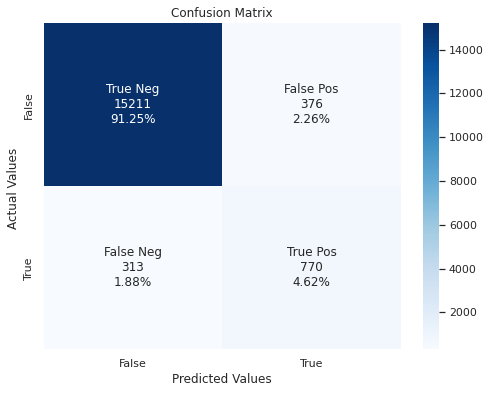

In [65]:
params_APPNP = {
    "n_hidden" : 256,
    "n_layers" : 2,
    "weight_decay" : 0.,
    "bias" : False,
    "dropout" : 0.2,
    "epochs" : 1000,
    "lr" : 0.001,
    "posweight" : 0.7,
    "alpha" : 0.2,
    "k" : 20,
}

# train on graph bidirectional edges
acc, prec, rec, f1 = train_eval_model('APPNP', APPNP, g_bi, features, **params_APPNP)

In [66]:
results = results.append({'model':'APPNP elliptic','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

In [67]:
results.iloc[[1,2]][['model','rec','pre','f1','acc']].round(3)

,model,rec,pre,f1,acc
1,rf,0.528,0.964,0.683,0.955
2,rf elliptic,0.717,0.953,0.818,0.979


In [70]:
results.iloc[[1,2]][['model','rec','pre','f1','acc']].round(3).to_latex(index=False)

'\\begin{tabular}{lrrrr}\n\\toprule\n      model &   rec &   pre &    f1 &   acc \\\\\n\\midrule\n         rf & 0.528 & 0.964 & 0.683 & 0.955 \\\\\nrf elliptic & 0.717 & 0.953 & 0.818 & 0.979 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [68]:
results.iloc[[5,6]][['model','rec','pre','f1','acc']].round(3)

,model,rec,pre,f1,acc
5,APPNP,0.541,0.687,0.605,0.936
6,APPNP elliptic,0.711,0.672,0.691,0.959


In [73]:
results.iloc[[5,6]][['model','rec','pre','f1','acc']].round(3).to_latex(index=False)

'\\begin{tabular}{lrrrr}\n\\toprule\n         model &   rec &   pre &    f1 &   acc \\\\\n\\midrule\n         APPNP & 0.541 & 0.687 & 0.605 & 0.936 \\\\\nAPPNP elliptic & 0.711 & 0.672 & 0.691 & 0.959 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [69]:
results.iloc[[0,1,3,4,5]][['model','rec','pre','f1','acc']].round(3)

,model,rec,pre,f1,acc
0,logit,0.676,0.153,0.249,0.629
1,rf,0.528,0.964,0.683,0.955
3,GAT,0.411,0.573,0.478,0.919
4,GCN,0.449,0.322,0.375,0.864
5,APPNP,0.541,0.687,0.605,0.936


In [74]:
results.iloc[[0,1,3,4,5]][['model','rec','pre','f1','acc']].round(3).to_latex(index=False)

'\\begin{tabular}{lrrrr}\n\\toprule\nmodel &   rec &   pre &    f1 &   acc \\\\\n\\midrule\nlogit & 0.676 & 0.153 & 0.249 & 0.629 \\\\\n   rf & 0.528 & 0.964 & 0.683 & 0.955 \\\\\n  GAT & 0.411 & 0.573 & 0.478 & 0.919 \\\\\n  GCN & 0.449 & 0.322 & 0.375 & 0.864 \\\\\nAPPNP & 0.541 & 0.687 & 0.605 & 0.936 \\\\\n\\bottomrule\n\\end{tabular}\n'